# Языковая модель (_language model_) своими руками 

Для начала напомним, как схематично выглядит типичная архитектура LSTM сети для задачи language modelling.

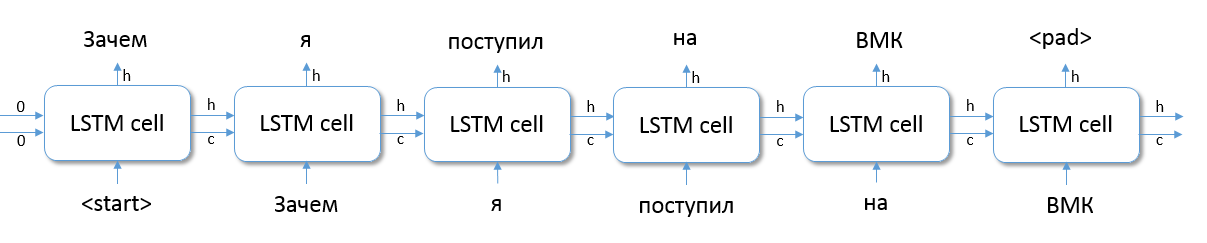

## Загрузка данных
Загрузим датасет с отзывами о фильмах IMDB.
Всего уникальных слов в корпусе 88 тысяч. Для предварительных экспериментов, будем работать только с 10 тысячами самых частотных слов. 

In [1]:
from pprint import pprint

import numpy as np

from keras.datasets import imdb

max_words_in_voc = 10000 

special_tokens = {0: '<pad>', 
                  1: '<start>', 
                  2: '<oov>'}

(x_train, y_train), (x_test, y_test) = imdb.load_data(
                                          path="imdb.npz",
                                          num_words=max_words_in_voc, # maximum number of indexed word, None = all
                                          skip_top=0, # skip n words with the highest occurance count
                                          maxlen=None, # truncate examples longer then N words
                                          seed=113, # random seed
                                          start_char=1, # index to be used for <start> token
                                          oov_char=2, # index to be used for unindexed words
                                          index_from=len(special_tokens)) # add `index_from` to all inidcies for regular words

Using TensorFlow backend.


### Изучим датасет.
Каждый пример представлен списком целых чисел. 
Эти целые числа - индексы слов.
В т.ч. специальные индексы:

1 - соответствует токену начала предложения {start}

2 - соответствует токену неизвестного слова {oov} (out of vocabulary) 

0 - будет соответсвовать специальному токену для заполнения пустого пространства {pad}

X:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]

Y:  1

Sentance length distribution:


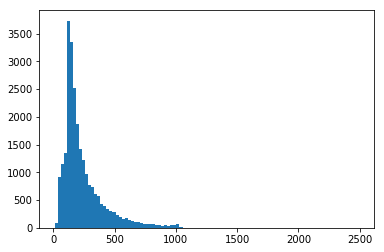

In [2]:
print("X: ", x_train[0])
print()
print("Y: ", y_train[0])
print()

%matplotlib inline
from matplotlib import pyplot as plt

print("Sentance length distribution:")
sent_lens = list(map(len, x_train))
lens = plt.hist(sent_lens, bins=100)

Мы видим, что бОльшая часть примеров в датасете имеет длину в 150-300 слов.

## Извлечём словарь
Для перевода индексов в слова нужно создать наш словарь, а так же укажем внесём в него наши специальные токены.

In [3]:
word2ind = imdb.get_word_index()

ind2word = {ind + len(special_tokens): word for word, ind in word2ind.items()} # each index is shifted by 3, as we stated in the load_imdb function
ind2word.update(special_tokens)
voc_size = min(max_words_in_voc, len(ind2word)) # maximum word index in our dataset + 

print("Vocabulary size = %d tokens" % voc_size)

def inds2text(inds_list):
    return ' '.join(map(ind2word.get, inds_list))

Vocabulary size = 10000 tokens


Проверим адекватность нашего словарь на примере случайного предложения.

In [4]:
sample_sentance_inds = x_train[0]
inds2text(sample_sentance_inds)

"<start> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

# Разбор работы сети на одном батче
Далее мы построим LSTM сеть для задачи Language Modelling и покажем, как запустить на ней один обучающий батч.

Выберем из наших данных несколько первых отзывов для пробного батча.

In [5]:
def get_sample_batch(batch_size):
    batch_X = x_train[:batch_size]
    return batch_X

batch_X = get_sample_batch(5)
batch_lens = [len(sent_inds) for sent_inds in batch_X]
print("Example lengths: ", batch_lens)

Example lengths:  [218, 189, 141, 550, 147]


### Приведение списков к матрице
Наш батч имеет тип "массив списков", в то время, как tensorflow принимает данные только в формате n-мерных массивов (обычно: np.ndarray).

Приведём наш батч к массиву фиксированного размера, обрезав слишком длинные отзывы и дополнив паддинг токенами {pad} слишком короткие.

In [6]:
from keras.preprocessing import sequence

def pad_batch(batch, max_seq_len):
    batch_padded = sequence.pad_sequences(batch, 
                                          maxlen=max_seq_len, # maximum length of the example
                                          padding='post', # from which end to pad short examples
                                          truncating='post') # from which end to truncate long examples
    return batch_padded

batch_padded = pad_batch(batch_X, 100)
print("Shape of X: ", batch_padded.shape)
print()
print("Sample example: ", batch_padded[1])
print()
print("Its text: ", inds2text(batch_padded[1]))

Shape of X:  (5, 100)

Sample example:  [   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26    4
  715    8  118 1634   14  394   20   13  119  954  189  102    5  207  110
 3103   21   14   69  188    8   30   23    7    4  249  126   93    4  114
    9 2300 1523    5  647    4  116    9   35 8163    4  229    9  340 1322
    4  118    9    4  130 4901   19    4 1002    5   89   29  952   46   37
    4  455    9   45   43   38 1543 1905  398    4 1649   26 6853    5  163
   11 3215    2    4 1153    9  194  775    7 8255]

Its text:  <start> big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the 

Операция `tf.reset_default_graph()` очищает текущий граф вычисления и позволяет начать создавать новый "с чистого листа".

In [7]:
import tensorflow as tf

tf.reset_default_graph()

Создадим словарь `hyper_parameters`, в котором мы будем хранить гиперпараметры сети и словарь `network_dict`, в котором мы будем хранить ключевые объекты этой сети.

In [8]:
hyper_parameters = dict()
hyper_parameters['bs'] = 5
hyper_parameters['max_len'] = 100
hyper_parameters['voc_size'] = voc_size

network_dict = dict()

### Создание placeholder'ов для входных данных
Плейсхолдеры - это ячейки, в которые будут передаваться входные данные.
В нашем случае, входными данными являются только индексы слов. Создадим необходимые плейсхолдеры для нашей сети.

In [9]:
def create_placeholders(hyper_parameters,
                        network_dict):
    network_dict['ph_X'] = tf.placeholder(shape=(hyper_parameters['bs'],
                                                 hyper_parameters['max_len']), 
                                          dtype=tf.int32, 
                                          name="text_input") # bs, max_len

create_placeholders(hyper_parameters, network_dict)

# Check that placeholder have the expected shape
print("ph_X shape:", network_dict['ph_X'].shape)

ph_X shape: (5, 100)


## Создание векторных представлений
Почти всегда, когда мы работаем со словами, мы хотим переводить индексы слов во float вектора небольшой размерности. Такие вектора, назывются _векторными представлениями слов_ (_word embeddings_).
Создадим матрицу векторных представлений размера (*размер словаря*, *размер векторных представлений*) и создадим узел в вычислительном графе, который будет "превращать" входные индексы слов в векторные представления.

In [10]:
hyper_parameters['emb_size'] = 256

def create_embedding_layer(hyper_parameters, 
                           network_dict):
    var_embs = tf.get_variable('var_embs', shape=[hyper_parameters['voc_size'], 
                                                                  hyper_parameters['emb_size']],
                                               dtype=tf.float32,
                                               initializer=tf.random_uniform_initializer(-1, 1),
                                               trainable=True)
    
    
    network_dict['word_embeddings'] = \
        tf.nn.embedding_lookup(var_embs, network_dict['ph_X']) # (bs, max_len, emb_size)

create_embedding_layer(hyper_parameters, network_dict)

# Check that tensor have expected shape
print("Shape of `word_embeddings` tensor:", network_dict['word_embeddings'].shape)

Shape of `word_embeddings` tensor: (5, 100, 256)


## LSTM cell
Самостоятельно реализуем LSTM ячейку

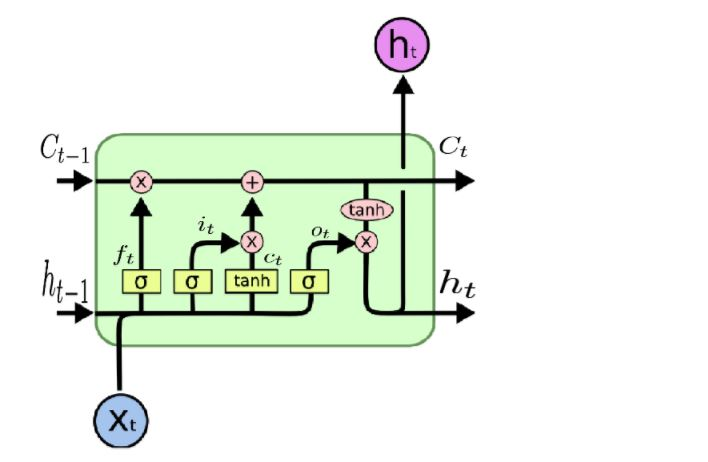


Создадим все необходимые переменные, которые в себе содержит LSTM ячейка.
Инициализировать значения будем случайными небольшими числами из нормального распределения со средним 0 и стандартным отклонением в 0.1. 

_Замечание: данная инициализация не обязательно является оптимальной, а просто приведена в качестве примера_

In [11]:
hyper_parameters['cell_size'] = 512

def create_lstm_variables(hyper_parameters, network_dict):
    emb_size = hyper_parameters['emb_size']
    cell_size = hyper_parameters['cell_size']
    # Input weights + bias
    network_dict['W_i'] = tf.get_variable('W_i', 
                          shape=[emb_size + cell_size, cell_size], 
                          dtype=tf.float32,
                          initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))


    network_dict['b_i'] = tf.get_variable('b_i', 
                          shape=[cell_size,], 
                          dtype=tf.float32,
                          initializer=tf.zeros_initializer())

    # Forget weights + bias
    network_dict['W_f'] = tf.get_variable('W_f', 
                          shape=[emb_size + cell_size, cell_size], 
                          dtype=tf.float32,
                          initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

    network_dict['b_f'] = tf.get_variable('b_f', 
                          shape=[cell_size,], 
                          dtype=tf.float32,
                          initializer=tf.zeros_initializer())
    
    # Memory weights + bias
    network_dict['W_c'] = tf.get_variable('W_c', 
                          shape=[emb_size + cell_size, cell_size], 
                          dtype=tf.float32,
                          initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))

    network_dict['b_c'] = tf.get_variable('b_c', 
                          shape=[cell_size, ], 
                          dtype=tf.float32,
                          initializer=tf.zeros_initializer())
    
    # Output weights + bias
    network_dict['W_o'] = tf.get_variable('W_o', 
                          shape=[emb_size + cell_size, cell_size], 
                          dtype=tf.float32,
                          initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    network_dict['b_o'] = tf.get_variable('b_o', 
                          shape=[cell_size,], 
                          dtype=tf.float32,
                          initializer=tf.zeros_initializer())

create_lstm_variables(hyper_parameters, network_dict)

Напишем реализацию LSTM ячейки

In [12]:
def lstm_cell(word_embeddings, # (bs, embedding_size)
              h_t_1, # (bs, hidden_size)
              c_t_1, # (bs, hidden_size)
              network_dict): # (bs, hidden_size)
    W_i = network_dict['W_i']
    b_i = network_dict['b_i']
    W_o = network_dict['W_o']
    b_o = network_dict['b_o']
    W_f = network_dict['W_f']
    b_f = network_dict['b_f']
    W_c = network_dict['W_c']
    b_c = network_dict['b_c']
    concated_input = tf.concat([word_embeddings, h_t_1], axis=1) # (bs, hidden_size + embedding_size)
    forget_gate = tf.nn.sigmoid(tf.matmul(concated_input, W_f) + b_f) # (bs, hidden_size)
    input_gate = tf.nn.sigmoid(tf.matmul(concated_input, W_i) + b_i) # (bs, hidden_size)
    update = tf.nn.tanh(tf.matmul(concated_input, W_c) + b_c) # (bs, hidden_size)
    output_gate = tf.nn.sigmoid(tf.matmul(concated_input, W_o) + b_o) # (bs, hidden_size)
    c_t = c_t_1 * forget_gate + (update * input_gate) # (bs, hidden_size)
    h_t = tf.nn.tanh(c_t) * output_gate # (bs, hidden_size)
    return h_t, c_t # (bs, hidden_size), (bs, hidden_size)

По очереди прогоним каждое t-ое слово в батче через LSTM ячейку и запомним её выводы.

In [13]:
def create_lstm(hyper_parameters, network_dict):
    word_embeddings = network_dict['word_embeddings'] # (batch_size, max_len, embedding_size)
    outputs = []
    # create special constant for first timestep cell state
    zero_state = tf.zeros(shape=(hyper_parameters['bs'], hyper_parameters['cell_size']))
    c_t = zero_state
    h_t = zero_state
    # iterate over each word
    for timestep in range(hyper_parameters['max_len']):
        # get a slice for t-th word of each batch
        one_word_batch = word_embeddings[:, timestep, :]  # (bs, embedding_size)
        # compute lstm_cell
        h_t, c_t = lstm_cell(one_word_batch, h_t, c_t, network_dict)
        # remember the output for each step
        outputs.append(h_t)
    network_dict['lstm_outputs'] = outputs # list of size `max_len` of tensors (bs, hidden_size)
    
create_lstm(hyper_parameters, network_dict)

Проверим измерения у выводов LSTM.
Они имеют тип "список тензоров размера (размер_батча, размер ячейки)"

In [14]:
lstm_outputs = network_dict['lstm_outputs']
print("len(lstm_outputs): ", len(lstm_outputs))
print("stm_outputs[0].shape: ", lstm_outputs[0].shape)

len(lstm_outputs):  100
stm_outputs[0].shape:  (5, 512)


Наконец, посчитаем функцию потерь.
Для этого выход LSTM на _каждом шаге_ надо привести к вектору длиной в _размер словаря_.
Такой вектор называется logits и его i-я компонента соответсвует ненормализованной вероятности того, что на следующем шаге встретится слово с индексом i.

Затем такой вектор пропускается через softmax слой и считается кросс-энтропия с целевой переменной (то есть настоящим словом, которое должно встретится на следующем шаге).

В tensorflow из соображений эффективности вычисление softmax и кросс-энтропии объединено в одну операцию.
В нашем случае это `tf.nn.sparse_softmax_cross_entropy_with_logits`, которая принимает на вход `logits` - тэнзор размера (_размер батча_, _размер словаря_) и `targets` - целочисленный тензор размера (_размер батча_, ), содержащий индексы слов. Эта операция возвращает кросс энтропию для каждого примера в батче, поэтому для финальной функции потерь мы берём среднее значение всех потерь в батче.

In [15]:
def create_loss_function(hyper_parameters, network_dict):
    lstm_outputs = network_dict['lstm_outputs'] # list of size `max_len` of tensors (bs, hidden_size)
    input_words_inds = network_dict['ph_X'] # (batch_size, max_example_len)
    
    input_words = input_words_inds[:, 1:] # shift all input words left by 1
    # and add <pad> token index (1) at the end each example
    ones_vector = tf.ones(shape=[hyper_parameters['bs'],1], dtype=tf.int32)
    target_words =  tf.concat([input_words, ones_vector], axis = 1) # (bs, max_len)
    
    W = tf.get_variable('W_softmax', # softmax layer weights
                      shape=[hyper_parameters['cell_size'], hyper_parameters['voc_size']], 
                      dtype=tf.float32,
                      initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    b = tf.get_variable('b_softmax', # softmax layer bias
                        shape=[hyper_parameters['voc_size'],], 
                        dtype=tf.float32,
                        initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
    
    loss = tf.constant(0.0, dtype=tf.float32)
    for t in range(hyper_parameters['max_len']):
        logits = tf.matmul(lstm_outputs[t], W) + b # (bs, voc_size)
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                      labels=target_words[:, t]) # (bs,)
        loss_t = tf.reduce_mean(softmax_loss) # batch_size, max_example_len
        loss += loss_t
    network_dict['loss'] = loss 

create_loss_function(hyper_parameters, network_dict)

И последний элемент сети - определение операции оптимизатора.

_Совет из субъективного опыта: для начальных экспериментов, используйте адам-оптимизатор. Обычный SGD и Momentum без тонкой настройки их параметров могут работать очень плохо на LSTM_

In [16]:
hyper_parameters['lr'] = 0.001 # learning rate

def create_training_operation(hyper_parameters, network_dict):
    optimizer = tf.train.AdamOptimizer(learning_rate=hyper_parameters['lr'])
    # some other options:
    # optimizer = tf.train.GradientDescentOptimizer(learning_rate=hyper_parameters['lr'])
    # optimizer = tf.train.MomentumOptimizer(learning_rate=hyper_parameters['lr'], momentum=0.9)
    network_dict['train_op'] = optimizer.minimize(network_dict['loss'])

Создадим функцию, которая создаёт всё нашу сеть по гиперпараметрам и функцию, которая описывает нам все обучаемые параметры

In [17]:
def create_network(hyper_parameters):
    tf.reset_default_graph()
    network_dict = dict()
    create_placeholders(hyper_parameters, network_dict)
    create_embedding_layer(hyper_parameters, network_dict)
    create_lstm_variables(hyper_parameters, network_dict)
    create_lstm(hyper_parameters, network_dict)
    create_loss_function(hyper_parameters, network_dict)
    create_training_operation(hyper_parameters, network_dict)
    return network_dict

def describe_graph():
    print("Trainable variables:")
    for var in tf.trainable_variables():
        print(var.name, ':',  var.shape)
    print()
    total_parameters = np.sum([np.prod(var.shape.as_list()) for var in tf.trainable_variables()])
    print("Total parameter count:", total_parameters)

В следующем окне варируя гиперпараметрами можно создавать сети разного размера и оценивать количество параметров в них

In [18]:
hyper_parameters = {'bs': 5, 
                    'voc_size': voc_size,
                    'cell_size': 512, 
                    'emb_size': 256, 
                    'max_len': 100, 
                    'lr': 0.001}

network_dict = create_network(hyper_parameters)
describe_graph()

Trainable variables:
var_embs:0 : (10000, 256)
W_i:0 : (768, 512)
b_i:0 : (512,)
W_f:0 : (768, 512)
b_f:0 : (512,)
W_c:0 : (768, 512)
b_c:0 : (512,)
W_o:0 : (768, 512)
b_o:0 : (512,)
W_softmax:0 : (512, 10000)
b_softmax:0 : (10000,)

Total parameter count: 9264912


Можно переходить к процессу обучения.
Для начала, создадим сессию и инициализруем все переменные.

Определим функцию для исполнения одного шага градиентного спуска.

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

def train_step(network_dict, input_batch, tf_session, do_backward=True):
    loss = network_dict['loss']
    ph_X = network_dict['ph_X']
    if do_backward:
        train_op = network_dict['train_op']
        _, loss_value = tf_session.run([train_op, loss], feed_dict={ph_X: input_batch})
    else:
        loss_value = sess.run(loss, feed_dict={ph_X: input_batch})
    return loss_value

И произведём один шаг обучния.

Используя ваш системный монитор ресурсов, попробуйте определить, сколько оперативной памяти потребовалось при запуске этого шага.

Часто, вы будете хотеть максимально задействовать ресурсы вашей машины, не допуская переполнения оперативной памяти. Поэтому такие параметры, как размер батча, длина последовательности и размер скрытых состояний рекомендуется подстраивать под возможности вашей машины. _(но не забывайте, что не всегда бОльшая сеть работает лучше)_

In [20]:
import time

batch = get_sample_batch(hyper_parameters['bs'])
batch_padded = pad_batch(batch, hyper_parameters['max_len'])

t0 = time.time()
loss_value = train_step(network_dict, batch_padded, sess, do_backward=False)
print("Forward pass took %.2f seconds" % float(time.time() - t0))
print("Loss = %f" % loss_value)
print()

t0 = time.time()
loss_value = train_step(network_dict, batch_padded, sess, do_backward=True)
print("One forward-backward pass took %.2f seconds" % float(time.time() - t0))
print("Loss = %f" % loss_value)
sess.close()

Forward pass took 0.91 seconds
Loss = 930.564880

One forward-backward pass took 3.67 seconds
Loss = 930.564880


# Truncated back propagation

Часто мы не обладаем большим объёмом оперативной памяти (а особенно когда мы хотим производить вычисления на GPU, в которых объём памяти обычно лежит в дипозоне от 1 до 10 ГБ), но при этом мы не хотим жертвовать размером словаря или длиной наших примеров.

Идея подхода заглючается в том, чтобы разбивать батчи на несколько сегментов небольшой длины (вдоль оси тайм-степов) и делать forward-backward проходы не на всём длинном батче, а на этих небольших сегментах.

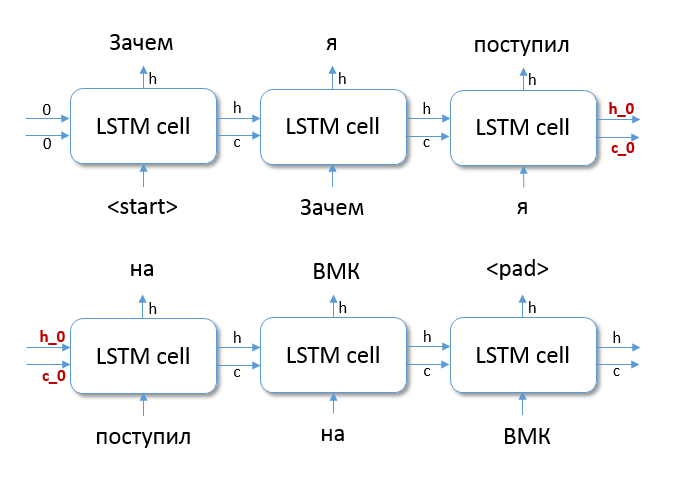


Создадим функцию для генерации таких сегментов. 
Раньше, мы воссоздавали переменную `target_words` (слова, со следующего тайм-степа) внутри сети из содержимого плейсхолдера `ph_X`. Теперь же `ph_X` будет содержать не весь отзыв, а только его небольшой кусочек, поэтому для переменной `target_words` нам будет нужно знать слово из следующего сегмента. Теперь будем передавать эту переменную на каждом сегменте плейсхолдеры.

In [21]:
def padded_segments(batch_X, segment_size):
    sent_lens = map(len, batch)
    segments_X = []
    segments_y = []
    num_segments = int(np.ceil(max(sent_lens) / segment_size))
    
    batch_padded_X = sequence.pad_sequences(batch, 
                                          maxlen=num_segments * segment_size, 
                                          padding='post', 
                                          truncating='post')
    batch_padded_y = np.concatenate([batch_padded_X, 
                                     np.zeros(shape=(batch_padded_X.shape[0], 1), dtype='int')], axis=1)
    batch_padded_y = batch_padded_y[:, 1:]
    for i in range(num_segments):
        segments_X.append(batch_padded_X[:, i * segment_size: (i+1) * segment_size])
        segments_y.append(batch_padded_y[:, i * segment_size: (i+1) * segment_size])
    return segments_X, segments_y


Добавим входы `ph_h_0` и `ph_c_0`, которые будут соответсвовать начальным состояним первой LSTM ячейки в сегменте, а также теперь будем вручную передавать лейблы через плейсхолдер `ph_y`.

In [22]:
def create_placeholders(hyper_parameters,
                        network_dict):
    network_dict['ph_X'] = tf.placeholder(shape=(hyper_parameters['bs'], hyper_parameters['max_len']), 
                                          dtype=tf.int32, 
                                          name="text_input")
    network_dict['ph_y'] = tf.placeholder(shape=(hyper_parameters['bs'], hyper_parameters['max_len']), 
                                          dtype=tf.int32, 
                                          name="lm_labels")
    network_dict['ph_h_0'] = tf.placeholder(shape=(hyper_parameters['bs'], hyper_parameters['cell_size']), 
                                             dtype=tf.float32, 
                                             name="ph_h_0")
    network_dict['ph_c_0'] = tf.placeholder(shape=(hyper_parameters['bs'], hyper_parameters['cell_size']), 
                                             dtype=tf.float32, 
                                             name="ph_c_0")

Вместо того, чтобы инициализировать нулями начальные состояния первой LSTM ячейки, присвоим им значения, полученные из плейсхолдеров `ph_h_0` и `ph_c_0`

In [23]:
def create_lstm(hyper_parameters, network_dict):
    word_embeddings = network_dict['word_embeddings'] 
    outputs = []
    zero_state = tf.zeros(shape=(hyper_parameters['bs'], hyper_parameters['cell_size']))
    h_t = network_dict['ph_h_0'] # <--
    c_t = network_dict['ph_c_0'] # <--
    for timestep in range(hyper_parameters['max_len']):
        one_word_batch = word_embeddings[:, timestep, :]
        # compute lstm_cell
        h_t, c_t = lstm_cell(one_word_batch, h_t, c_t, network_dict)
        outputs.append(h_t)
    network_dict['lstm_outputs'] = outputs 
    network_dict['h_final'] = h_t
    network_dict['c_final'] = c_t
    

Изменим нашу функцию потерь, чтобы она зависела от `ph_y`

In [24]:
def create_loss_function(hyper_parameters, network_dict):
    lstm_outputs = network_dict['lstm_outputs'] 
    target_words = network_dict['ph_y'] 
    
    W = tf.get_variable('W_softmax', 
                      shape=[hyper_parameters['cell_size'], hyper_parameters['voc_size']], 
                      dtype=tf.float32, 
                      initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b_softmax', 
                        shape=[hyper_parameters['voc_size'],], 
                        dtype=tf.float32,
                        initializer=tf.initializers.zeros())
    
    loss = tf.constant(0.0, dtype=tf.float32)
    for t in range(hyper_parameters['max_len']):
        logits = tf.matmul(lstm_outputs[t], W) + b 
        softmax_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, 
                                                                      labels=target_words[:, t]) # (bs,)
        loss_t = tf.reduce_mean(softmax_loss) 
        loss += loss_t
    network_dict['loss'] = loss

Теперь вместо того, чтобы пропускать весь батч через сеть, будем пропускать по одному сегменту, запоминая выходное состояния LSTM ячейки на последнем таймстепе и передавая его следующему запуску в качестве `h_t_0` и `h_c_0`.

In [25]:
def train_step(network_dict, input_segements, tf_session, do_backward=True):
    loss = network_dict['loss']
    ph_X = network_dict['ph_X']
    ph_y = network_dict['ph_y']
    
    ph_h_0 = network_dict['ph_h_0']
    ph_c_0 = network_dict['ph_c_0']
    
    zero_state = np.zeros(shape=(hyper_parameters['bs'], hyper_parameters['cell_size']))
    
    h_final = network_dict['h_final']
    c_final = network_dict['c_final']
    
    if do_backward:
        train_op = network_dict['train_op']
        run_ops = [h_final, c_final, loss, train_op]
    else:
        run_ops = [h_final, c_final, loss]
    
    h = zero_state
    c = zero_state
    losses = []
    
    segments_X, segments_y = input_segements
    for i in range(len(segments_X)):
        result = tf_session.run(run_ops, feed_dict={ph_X: segments_X[i],
                                                    ph_y: segments_y[i],
                                                    ph_h_0: h,
                                                    ph_c_0: c})
        h, c, loss = result[0], result[1], result[2]
        losses.append(loss)
    return np.mean(losses)

Обратите внимание, что в наших гиперпапраметрах `max_len` теперь играет роль размера сегмента.

Запустим всё вместе на том же самом батче.

In [26]:
hyper_parameters = {'bs': 5, 
                    'voc_size': voc_size,
                    'cell_size': 512, 
                    'emb_size': 256, 
                    'max_len': 100, 
                    'lr': 0.001}


network_dict = create_network(hyper_parameters)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    import time

    batch = get_sample_batch(hyper_parameters['bs'])
    segments = padded_segments(batch, hyper_parameters['max_len'])
    t0 = time.time()
    loss_value = train_step(network_dict, segments, sess, do_backward=False)
    print("Forward pass took %.2f seconds" % float(time.time() - t0))
    print("Loss = %f" % loss_value)
    print()

    t0 = time.time()
    loss_value = train_step(network_dict, segments, sess, do_backward=True)
    print("One forward-backward pass took %.2f seconds" % float(time.time() - t0))
    print("Loss = %f" % loss_value)

Forward pass took 3.14 seconds
Loss = 930.559753

One forward-backward pass took 11.92 seconds
Loss = 833.912598


Производительность данной модели на CPU (с 32 ГБ ОЗУ)

<table>
    <tr>
        <td>
           Размер сегмента
        </td>
        <td>
           Прямой прогон (секунды)
        </td>
        <td>
           Прямой + обратный прогон (секунды)
        </td>
    </tr>
    <tr>
        <td>
           Целый батч, обрезанный до 100 слов
        </td>
        <td>
           3
        </td>
        <td>
           13
        </td>
    </tr>
    <tr>
        <td>
           Целый батч, обрезанный до 200 слов
        </td>
        <td>
           8
        </td>
        <td>
           162
        </td>
    </tr>
    <tr>
        <td>
           Разбиение на сегменты по 50 слов (11 сегментов)
        </td>
        <td>
           19
        </td>
        <td>
           56
        </td>
    </tr>
    <tr>
        <td>
           Разбиение на сегменты по 100 слов (6 сегментов)
        </td>
        <td>
           21
        </td>
        <td>
           73
        </td>
    </tr>
    <tr>
        <td>
           Разбиение на сегменты по 200 слов (3 сегмента)
        </td>
        <td>
           21
        </td>
        <td>
           468
        </td>
    </tr>

</table>

## Использование выскоуровневых функций tensorflow

Для скорости разработки и скорости обучения модели рекомендуется использовать встроенные tensorflow функции для создания рекурентных сетей.

Функции создания LSTM ячеек:
- `tf.contrib.rnn.BasicLSTMCell` - реализация LSTM ячейки
- `tf.contrib.rnn.GRUCell` - реализация GRU ячейки (содержит меньше параметров, чем LSTM), многие рекомендуют использовать именно её вместо обычной LSTM ячейки
- людям, использующим NVidea карты для обучения (требуют настройки), tensorflow рекомендует использовать специальные ячейки, оптимизированные под CudNN, читайте про них здесь https://www.tensorflow.org/api_docs/python/tf/contrib/cudnn_rnn

Функции "развёртывания" рекурентных сетей
- `tf.nn.static_rnn` - функция для "развёртывания" LSTM сети для последовательностей фиксированной длины
- `tf.nn.dynamic_rnn` - функция для "развёртывания" LSTM сети для последовательностей переменной длины (в документации рекомендуется использовать именно этот вариант, предоставляющий более гибкие возможности
- `tf.contrib.seq2seq.sequence_loss` - функция для применения функции потерь к каждому выходу LSTM сети

При работе над своими проектами, я настоятельно рекмоендую ознакомиться с документацией по этим функциям  https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn , https://www.tensorflow.org/api_docs/python/tf/contrib/seq2seq/sequence_loss. Хотя бы с описанием их обязательных аргументов.

Перепишем нашу программу, используя эти функции.
Для начала перейдём от фиксированного размера батча и длины текстовых примеров к нефиксированным.

In [27]:
hyper_parameters = {'bs': 5, # this means, that batch size can be different for the various runs
                    'voc_size': voc_size,
                    'cell_size': 512, 
                    'emb_size': 256, 
                    'max_len': 200,  # same as batch size
                    'lr': 0.001}


def create_placeholders(hyper_parameters,
                        network_dict):
    ph_X = tf.placeholder(shape=(hyper_parameters['bs'], hyper_parameters['max_len']), 
                          dtype=tf.int32, 
                          name="text_input")
    network_dict['ph_X'] = ph_X
    network_dict['ph_y'] = tf.placeholder(shape=(hyper_parameters['bs'], hyper_parameters['max_len']), 
                          dtype=tf.int32, 
                          name="lm_labels")
    # dynamically retrieve batch size in runtime (required, when we work with batch_size = None)
    network_dict['bs_dynamic'] = tf.shape(ph_X)[0]
    
    # retrieve lengths of the examples during runtime
    non_zero_ids = tf.not_equal(ph_X, 0)
    non_zero_total = tf.reduce_sum(tf.cast(non_zero_ids, tf.int32), axis = 1)
    network_dict['example_lens'] = non_zero_total
    

model = {}
tf.reset_default_graph()
create_placeholders(hyper_parameters, model)

batch_padded = pad_batch(batch_X, 200)
print("Padded batch shape", batch_padded.shape)
print("True batch lens", batch_lens)

# And test our new tensors
with tf.Session() as sess:
    print("Batch size = ", sess.run(model['bs_dynamic'], feed_dict={model['ph_X']: batch_padded}))
    print("Example lens = ", sess.run(model['example_lens'], feed_dict={model['ph_X']: batch_padded}))
create_embedding_layer(hyper_parameters, model)

Padded batch shape (5, 200)
True batch lens [218, 189, 141, 550, 147]
Batch size =  5
Example lens =  [200 189 141 200 147]


Теперь изменим функции создания LSTM ячейки. Теперь вместо сохранения `c` и `h`, мы будем передавать состояние LSTM ячейки через высокоуровневый объект `state`.

In [28]:
def create_lstm_variables(hyper_parameters, network_dict):
    pass # let tensorflow functions take care of internal LSTM parameters



def create_lstm(hyper_parameters, network_dict):
    word_embeddings = network_dict['word_embeddings'] # (batch_size, max_len, embedding_size)
    ph_X = network_dict['ph_X']
    bs = network_dict['bs_dynamic']
    num_units = hyper_parameters['cell_size']
    example_lens = network_dict['example_lens']
    
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_units, state_is_tuple=True)
    network_dict['lstm_cell'] = lstm_cell
    
    
    outputs = []
    
    # actually, this operation creates a placeholder
    tf_zero_state = lstm_cell.zero_state(batch_size = bs, dtype=tf.float32)
    network_dict['initial_state'] = tf_zero_state
    
    network_outputs, network_state = tf.nn.dynamic_rnn(inputs=word_embeddings, 
                                                       cell=lstm_cell, 
                                                       initial_state=tf_zero_state,
                                                       sequence_length=example_lens)

    network_dict['lstm_outputs'] = network_outputs # bs , max_len, lstm_size
    network_dict['lstm_final_state'] = network_state # LSTMStateTuple (bs, 512)

create_lstm(hyper_parameters, model)

Создание переменный `W_softmax` и `b_softmax` теперь можно оставить функции `tf.contrib.layers.fully_connected`. 
Обратите внимание на вычисление`loss`. Функция `sequence_loss` зануляет все функции потерь в тех местах, где входной отзыв был дополнен `<pad>` токенами. Поэтому будем брать не среднее от матрицы всех функций потерь в нашем батче, а будем брать среднее только от ненулевых функций потерь в нашем батче.

In [29]:
def create_loss_function(hyper_parameters, network_dict):
    lstm_outputs = network_dict['lstm_outputs'] 
    target_words = network_dict['ph_y'] 
    example_lens = network_dict['example_lens']
    
    # W and b will be initialized in fully_connected
    lm_logits = tf.contrib.layers.fully_connected(lstm_outputs, 
                                                  num_outputs=voc_size,
                                                  activation_fn=None) # bs , max_len, voc_size
    sequence_mask = tf.sequence_mask(example_lens, dtype=tf.float32)
    
    loss = tf.contrib.seq2seq.sequence_loss(logits=lm_logits, 
                                            targets=target_words, 
                                            weights=sequence_mask,
                                            average_across_batch=False, 
                                            average_across_timesteps=False,
                                            softmax_loss_function=tf.nn.sparse_softmax_cross_entropy_with_logits)
    network_dict['loss'] = tf.reduce_sum(loss) / tf.cast(tf.reduce_sum(example_lens), dtype=tf.float32)

create_loss_function(hyper_parameters, model)

Во время обучения, будем теперь передавать не `h` и `c`, а одно состояние. При том для вычисления первого сегмента, мы не определяем значение переменной `lstm_init_state`. По умолчанию, она равна 0.

Так же изменилась функция вычисления loss для логов из-за того, что теперь последний сегмент может отличаться по длине от всех остальных.

In [30]:
def train_step(network_dict, input_segements, tf_session, do_backward=True):
    loss = network_dict['loss']
    ph_X = network_dict['ph_X']
    ph_y = network_dict['ph_y']
    
    lstm_init_state = network_dict['initial_state']
    lstm_final_state = network_dict['lstm_final_state']
    
    if do_backward:
        train_op = network_dict['train_op']
        run_ops = [lstm_final_state, loss, train_op]
    else:
        run_ops = [lstm_final_state, loss]

    losses = []
    segments_X, segments_y = input_segements
    for i in range(len(segments_X)):
        feed_dict = {ph_X: segments_X[i], ph_y: segments_y[i]}
        if i != 0:
            feed_dict[lstm_init_state] = final_state
        result = tf_session.run(run_ops, feed_dict=feed_dict)
        final_state = result[0]
        loss = result[1]
        losses.append(loss * segments_X[i].shape[1]) # loss * seg_len
    return np.sum(losses) / np.sum([segment.shape[1] for segment in segments_X]) # honestly, that's not a perfect
                                                                                 #  averaging for segment losses
                                                                                 #  but this loss is used only
                                                                                 #  for vizualisation of 
                                                                                 #  learning process 

Главное отличие разбиения батча на сегменты заключается в том, что мы не пытаемся разбить его на сегменты _равной_ длины. Мы позволяем последнему сегменту быть меньше остальных.

In [31]:
def padded_segments(batch_X, segment_size):
    sent_lens = map(len, batch_X)
    segments_X = []
    segments_y = []
    num_segments = int(np.ceil(max(sent_lens) / segment_size))
    
    batch_padded_X = sequence.pad_sequences(batch_X, 
                                          maxlen=None, # num_segments * segment_size, 
                                          padding='post', 
                                          truncating='post')
    batch_padded_y = np.concatenate([batch_padded_X, 
                                     np.zeros(shape=(batch_padded_X.shape[0], 1), dtype='int')], axis=1)
    batch_padded_y = batch_padded_y[:, 1:]
    for i in range(num_segments):
        segments_X.append(batch_padded_X[:, i * segment_size: (i+1) * segment_size])
        segments_y.append(batch_padded_y[:, i * segment_size: (i+1) * segment_size])
    return segments_X, segments_y

Наконец запустим нашу сеть.
Изученных подходов уже достаточно, чтобы построить несложную LSTM для задачи Language Modelling и обучить её в домашних условиях.

Обратите внимания, что архитектура сети не имеет фиксированного размера батча и длины сегмента. Это означает, что она динамически подстраивается под входные данные.

In [32]:
batch_size = 32
segment_len = 100

hyper_parameters = {'bs': None, # this means, that batch size can be different for the various runs
                    'voc_size': voc_size,
                    'cell_size': 512, 
                    'emb_size': 256, 
                    'max_len': None,  # same as batch size
                    'lr': 0.01}

segments = padded_segments(batch_X, 40)
network_dict = create_network(hyper_parameters)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    import time

    batch = get_sample_batch(batch_size)
    segments = padded_segments(batch, segment_len)
    t0 = time.time()
    loss_value = train_step(network_dict, segments, sess, do_backward=False)
    print(loss_value)
    print("Forward pass took %.2f seconds" % float(time.time() - t0))
    print("Loss = %f" % loss_value)
    print()

    t0 = time.time()
    loss_value = train_step(network_dict, segments, sess, do_backward=True)
    print("One forward-backward pass took %.2f seconds" % float(time.time() - t0))
    print("Loss = %f" % loss_value)

9.21249617757
Forward pass took 7.16 seconds
Loss = 9.212496

One forward-backward pass took 20.14 seconds
Loss = 7.447079
